# Data Cleaning & Pre-Processing

In [1025]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cleaning_functions as cf
from unidecode import unidecode # source: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string 

In [1026]:
# Source (via Wine.com) : https://www.kaggle.com/datasets/salohiddindev/wine-dataset-scraping-from-wine-com (prices in USD)
df_wine_com = pd.read_csv("../data/original_datasets/wine_com.csv", encoding='utf-16')

# Source (via Vivino.com): https://www.kaggle.com/datasets/budnyak/wine-rating-and-price (prices in EUR)
df_viv_1 = pd.read_csv('../data/original_datasets/vivino_one.csv')
df_viv_1.drop(columns=['Unnamed: 0'], inplace=True)

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_viv_2 = pd.read_csv('../data/original_datasets/vivino_two.csv')

# Source (via Vivino.com): https://www.kaggle.com/datasets/joshuakalobbowles/vivino-wine-data (prices in EUR)
df_val = pd.read_csv('../data/original_datasets/validation_set.csv')

In [1027]:
# Make column names snake_case.
df_viv_1.columns = [col.lower().replace(' ', '_') for col in df_viv_1.columns]
df_viv_2.columns = [col.lower().replace(' ', '_') for col in df_viv_2.columns]
df_wine_com.columns = [col.lower().replace(' %', '').replace(' ', '_') for col in df_wine_com.columns]
df_val.columns = [col.lower().replace(' ', '_') for col in df_val.columns]

# Cleaning wine.com Dataset

In [1028]:
df_wine_com.head()

,names,color_wine,prices,ml,ratings,ratingsnum,countrys,abv,rates
0,00 Wines VGW Chardonnay 2017,White Wine,79.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",13.0,"JS, WE, WS"
1,00 Wines VGR Pinot Noir 2019,Red Wine,99.99$,750,0.0,0,"Pinot Noir from Willamette Valley, Oregon",12.9,"WE, JS, RP"
2,00 Wines EGW Chardonnay 2019,White Wine,115.99$,750,0.0,0,"Chardonnay from Willamette Valley, Oregon",0.0,"JS, RP, WE"
3,100 Nails Ranch Pinot Noir 2019,Red Wine,16.99$,750,0.0,0,"Pinot Noir from Central Coast, California",14.2,WW
4,100 Nails Ranch Chardonnay 2019,White Wine,16.99$,750,0.0,0,"Chardonnay from Sonoma County, California",14.2,0


In [1029]:
df_wine_com.shape

(15254, 9)

In [1030]:
df_wine_com.drop_duplicates(inplace=True)

In [1031]:
# Correct prices 
df_wine_com['prices'] = df_wine_com['prices'].str.replace(',', '').str.replace('$', '').astype(float)

In [1032]:
# Extract column for vintage from name column
df_wine_com['vintage'] = df_wine_com['names'].apply(cf.get_vintage)
df_wine_com['vintage'].value_counts().head()

vintage
2019    3050
2020    2873
2018    2317
2021    1788
2017    1373
Name: count, dtype: int64

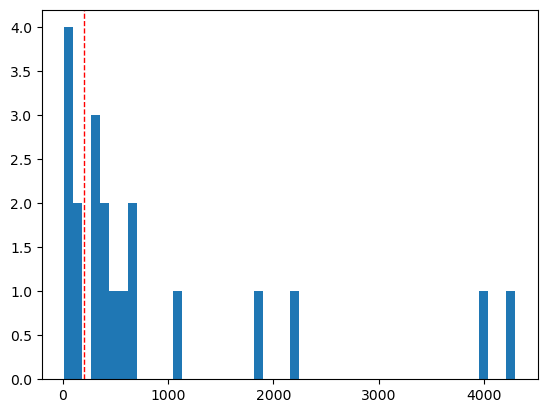

In [1033]:
# Investigate very old wines
old_wines = df_wine_com[df_wine_com['vintage'] < '1985']
plt.hist(old_wines['prices'], bins=50)
plt.axvline(x=200, color='r', linestyle='dashed', linewidth=1, label='$200');

In [1034]:
'''
Remove vintage for wines below $200 in price and 'older' than 1985, having investgated them 
individually these are wines with the established year of the producer in their name 
not the year grape was picked.
'''
df_wine_com.loc[(df_wine_com['prices'] < 200) & (df_wine_com['vintage'] < '1985'), 'vintage'] = 'unknown'

In [1035]:
# Keep only 750ml bottles.
df_wine_com = df_wine_com[df_wine_com['ml'] == 750].copy()
df_wine_com.drop(columns=['ml'], inplace=True)

In [1036]:
df_wine_com['color_wine'].value_counts()

color_wine
Red Wine                 8983
White Wine               3687
Sparkling & Champagne     959
Pink and Rosé             413
0                         199
Collectible                25
Screw Cap                  20
Boutique                    7
Green Wine                  4
Great Gift                  2
Name: count, dtype: int64

In [1037]:
df_wine_com['color_wine'] = df_wine_com['color_wine'].apply(cf.remove_accents)
df_wine_com['wine_variety'] = df_wine_com['color_wine'].apply(cf.get_wine_variety)
df_wine_com.drop(columns=['color_wine'], inplace=True)
df_wine_com['wine_variety'].value_counts()

wine_variety
red          8983
white        3687
sparkling     959
rose          413
other         257
Name: count, dtype: int64

In [1038]:
# Remove 'other' wine varieties
df_wine_com = df_wine_com[df_wine_com['wine_variety'] != 'unknown'].copy()

In [1039]:
# Rename columns 
df_wine_com.rename(columns = {'names' : 'name',
                            'prices' : 'price',
                            'ratings' : 'rating',
                            'ratingsnum': 'rating_qty', 
                            'rates' : 'reviewed_by'}, inplace = True)

In [1040]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [1041]:
df_wine_com['region'] = df_wine_com['countrys'].apply(cf.get_region)
# Drop 33 wines where region was not found 
df_wine_com = df_wine_com[df_wine_com['region'] != 'unknown'].copy()

In [1042]:
# Extract country name from country column 
df_wine_com['country'] = df_wine_com['countrys'].apply(cf.get_country)
df_wine_com['country'].value_counts()

country
France          4128
California      2845
Italy           2381
unknown         1363
Spain            926
Australia        433
Argentina        407
Washington       300
Germany          258
Oregon           241
Chile            219
Portugal         219
New Zealand      202
Other U.S.       107
South Africa      99
Austria           74
Greece            62
Canada             2
Name: count, dtype: int64

In [1043]:
# Investigate the unknown countries 
df_wine_com[df_wine_com['country'] == 'unknown']

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country
6,1000 Stories Bourbon Barrel Aged Prospectors P...,19.99,0.0,0,Cabernet Sauvignon from California,0.0,WW,2020,red,California,unknown
7,1000 Stories American Barrel Aged Pinot Noir 2020,17.99,0.0,0,Pinot Noir from California,14.5,0,2020,red,California,unknown
8,1000 Stories Bourbon Barrel Aged Zinfandel 2020,18.99,3.8,11,Zinfandel from California,15.5,WW,2020,red,California,unknown
9,1000 Stories Bourbon Barrel Aged Chardonnay 2019,19.99,4.4,10,Chardonnay from California,14.4,TP,2019,white,California,unknown
10,1000 Stories Bourbon Barrel Aged Prospectors P...,18.99,0.0,0,Cabernet Sauvignon from California,14.9,0,2018,red,California,unknown
...,...,...,...,...,...,...,...,...,...,...,...
15210,Vinos Atlantico Vera Vinho Verde Rose 2021,12.99,0.0,0,Rosé from Portugal,11.5,0,2021,rose,Portugal,unknown
15212,Vinos De Arganza Marques De Montejos Mencia 2020,13.99,0.0,0,Mencia from Spain,13.0,"JS, WW",2020,red,Spain,unknown
15214,Vinos De Arganza Alvarez De Toledo Godello 2021,11.99,4.8,29,Godello from Spain,0.0,WW,2021,white,Spain,unknown
15215,Vinos De Arganza Palacio De Arganza Cabernet S...,13.99,4.8,30,Other Red Blends from Spain,13.0,"JS, WW",2020,red,Spain,unknown


In [1044]:
df_wine_com.loc[df_wine_com['region'].isin(cf.us_states), 'country'] = 'United States'

In [1045]:
# All unknown countries are cases where no region was available. The country was populated in the region or a US state. 
region_problems = df_wine_com[df_wine_com['country'] == 'unknown']
region_problems['region'].value_counts()

region
Israel               115
South Africa         105
Chile                 70
Portugal              70
Spain                 69
France                60
Italy                 55
Argentina             32
Uruguay               23
Austria               23
Greece                23
Australia             20
Lebanon               11
England               10
Slovenia               9
Germany                9
Hungary                8
Croatia                6
Brazil                 5
New Zealand            3
Armenia                3
China                  2
Other                  2
Macedonia (FYROM)      2
Other U.S.             1
Name: count, dtype: int64

In [1046]:
# move those regions that are countries to the country column 
df_wine_com.loc[df_wine_com['country'] == 'unknown', 'country'] = df_wine_com.loc[df_wine_com['country'] == 'unknown', 'region']
# make those regions that are countries 'unknown'
df_wine_com.loc[df_wine_com['region'] == df_wine_com['country'], 'region'] = 'unknown'
# combine U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'Other U.S.', 'country'] = 'United States'
# combine all U.S. and Other U.S.
df_wine_com.loc[df_wine_com['country'] == 'California', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Washington', 'country'] = 'United States'
df_wine_com.loc[df_wine_com['country'] == 'Oregon', 'country'] = 'United States'
# rename macedonia 
df_wine_com.loc[df_wine_com['country'] == 'Macedonia (FYROM)', 'country'] = 'Macedonia'

df_wine_com['country'].value_counts()

country
France           4188
United States    4121
Italy            2436
Spain             995
Australia         453
Argentina         439
Portugal          289
Chile             289
Germany           267
New Zealand       205
South Africa      204
Israel            115
Austria            97
Greece             85
Uruguay            23
Lebanon            11
England            10
Slovenia            9
Hungary             8
Croatia             6
Brazil              5
Armenia             3
China               2
Other               2
Canada              2
Macedonia           2
Name: count, dtype: int64

In [1047]:
df_wine_com['grape_variety'] = df_wine_com['countrys'].apply(cf.get_grape_1)

In [1048]:
# EXTRACT PRODUCER NAMES 
# Step 1 - Match with producers from other datasets and custom list in cleaning_functions.py 
all_producers = list(df_viv_1['winery'].unique()) + list(df_viv_2['winery'].unique()) + cf.custom_producer_list
all_producers  = [cf.uniform_strings(word) for word in all_producers]
all_producers.remove('Domaine De La')

In [1049]:
df_wine_com['name'] = df_wine_com['name'].apply(cf.uniform_strings)

In [1050]:
# 71% of producers matched by finding producer names from other datasets and custom list in cleaning_functions.py
# X producers matched 4171 remaining (total 14266)
df_wine_com['producer_clean'] = df_wine_com['name'].apply(lambda x: cf.extract_string(x, all_producers))

In [1051]:
check_wine = df_wine_com[df_wine_com['producer_clean'] == 'review']
check_wine.shape
df_wine_com['producer_clean'].value_counts().head()

producer_clean
review          4170
Louis Latour      80
Sine Qua Non      57
Ridge             49
Chanson           35
Name: count, dtype: int64

In [1052]:
# test = 'Wine De LA Abbona'
# test1 = "Wine De LA Annabella"
# test2 = '1849 wine wine'
# test3 = 'Aj Adam D Hofberg'
# test4 = 'Ydooker Gigglepot'
# test5 = 'Mollydooker Blue Eyed Boy Shiraz 2020'
# test6 = 'Reira Dona Antonia 10 Year Tawny Port'
# test7 = 'Tamarack Cellars Firehouse Red 2019'
# test8 = 'Domaine De La Charbonniere Chateauneufdupape Mourre Des Perdrix 2016'
# extract_string(test8, all_producers)

In [1053]:
# STEP 2 - Isolate part before grape names in column 'name' import list of grape varieties.
# This removes grape and year from X leaving X for review. X producers remain that have not be captured by first 2 steps. 
grape_list_long = pd.read_csv('../data/grape_varieties.csv')
grape_list_long.drop(columns = ['Unnamed: 0'], inplace = True)
varietal_set_long = set(grape_list_long['Variety'].dropna().apply(lambda x: cf.uniform_strings(x).strip().lower()))

In [1054]:
# test = 'Chardonnay Vinny  oz Mc Vinard Malbec  2002'
# test1 = 'Vinny Mc Vinard Malbec Chardonnay Cats 2002'
# test2 = 'Vinny Mc Vinard don Don 2002'
# test3 = 'Vinny Mc Vinard Pinot Noir 2002'
# test4 = 'Chardon Don Vineyard Chardonnay 2020'
# test5 = 'Aj Adam Hofberg Reserve Riesling Trocken 2019' # ISSUE HERE WITH {GRAPE}{OTHER-STRING}{YEAR}
# test6 = 'Aj Adam Hofberg Reserve Riesling 2020'

# cf.remove_varietal(test6, varietal_set_long)

In [1055]:
df_wine_com['producer_varietal_removed'] = df_wine_com['name'].apply(lambda x : cf.remove_varietal(x, varietal_set_long))

In [1056]:
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review')]

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed
13,12 Linajes Crianza 2014,31.99,3.9,17,"Tempranillo from Ribera del Duero, Spain",14.5,WE,2014,red,Ribera del Duero,Spain,Tempranillo,12 Linajes,review
35,19 Crimes The Warden 2018,20.99,3.7,12,"Syrah/Shiraz from South East Australia, Australia",0.0,0,2018,red,South East Australia,Australia,Syrah/Shiraz,19 Crimes,review
36,19 Crimes Hard Chard 2021,20.99,3.0,13,Chardonnay from Australia,14.0,0,2021,white,unknown,Australia,Chardonnay,19 Crimes,review
37,19 Crimes Marthas Chard 2020,13.99,3.8,24,Chardonnay from California,13.8,0,2020,white,California,United States,Chardonnay,19 Crimes,review
38,19 Crimes The Uprising 2020,11.99,4.1,41,Other Red Blends from Australia,0.0,0,2020,red,unknown,Australia,Other Red Blends,19 Crimes,review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15242,Viticcio Chianti Classico 2018,21.99,0.0,0,"Sangiovese from Chianti Classico, Chianti, Tus...",14.0,0,2018,red,Chianti Classico,Italy,Sangiovese,Viticcio,review
15244,Vivaltus 2016,99.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",0.0,"D, RP",2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15246,Vivaltus La Fleur Vivaltus 2016,46.99,0.0,0,"Tempranillo from Ribera del Duero, Spain",14.5,RP,2016,red,Ribera del Duero,Spain,Tempranillo,Vivaltus,review
15247,Vivanco Rioja Blanco 2019,14.99,3.8,6,"Other White Blends from Rioja, Spain",13.0,0,2019,white,Rioja,Spain,Other White Blends,Vivanco,review


In [1057]:
df_wine_com.loc[df_wine_com['abv'] == 0, 'abv'] = np.nan

In [1058]:
#2047 producers remain that have not be captured by first 2 steps. 
df_wine_com[(df_wine_com['producer_varietal_removed'] == 'review') & (df_wine_com['producer_clean'] == 'review')].shape

(1956, 14)

In [1059]:
df_wine_com['producer_dirty'] = df_wine_com['name'].apply(cf.get_dirty_producer)

In [1060]:
# # Done iteratively to add to custom producer list in cleaning_functions
# for i in np.sort(df_wine_com['producer_dirty'].unique()):
#     print(i)

In [1061]:
# # Check --> (6405,)
# df_wine_com['producer_dirty'].unique().shape

In [1062]:
shorterned_df = df_wine_com[(df_wine_com['producer_clean'] == 'review') &(df_wine_com['producer_varietal_removed'] == 'review')]

In [1063]:
all_remaining_producers =  shorterned_df['producer_dirty'].value_counts().index
all_remaining_producers = all_remaining_producers.sort_values()

In [1064]:
# No minimum number of ratings set for this scrape. 
df_wine_com['rating_qty'].describe()

count    14266.000000
mean        10.439577
std         49.378628
min          0.000000
25%          0.000000
50%          0.000000
75%          6.000000
max       1829.000000
Name: rating_qty, dtype: float64

In [1065]:
df_wine_com['combined_methods_producer'] = df_wine_com.apply(cf.combine_methods, axis = 1)

In [1066]:
df_wine_com['combined_methods_producer'].value_counts()

combined_methods_producer
Louis Latour                     80
Sine Qua Non                     57
Ridge                            49
Chanson                          35
Guigal                           33
                                 ..
Le Coeur De La Reine Touraine     1
Chateau De Fieuzal                1
Le Casematte Peloro               1
Le Cardinale De S                 1
Frisk Prickly                     1
Name: count, Length: 4515, dtype: int64

In [1067]:
df_wine_com['producer'] = df_wine_com['combined_methods_producer']

In [1068]:
# Investgate wine of price 9999.99
df_wine_com[df_wine_com['price'] == 9999.99]
# This is a collectable highly prized wine producer Chateau Petrus, explaining the high price

,name,price,rating,rating_qty,countrys,abv,reviewed_by,vintage,wine_variety,region,country,grape_variety,producer_clean,producer_varietal_removed,producer_dirty,combined_methods_producer,producer
3810,Chateau Petrus 2016,9999.99,4.7,11,"Bordeaux Red Blends from Pomerol, Bordeaux, Fr...",14.5,"JS, RP, D, JD, WE, WS",2016,red,Pomerol,France,Bordeaux Red Blends,Petrus,review,Chateau Petrus,Petrus,Petrus


In [1069]:
# Convert price to GBP £ using https://www.xe.com/currencytables/ at exchange rate date of scrape. 
df_wine_com['price'] = round((df_wine_com['price'] * 0.8214659183132513),2)

In [1070]:
df_wine_com['from_vivino'] = False
df_wine_com.drop(columns=['producer_clean', 'producer_varietal_removed',
                            'producer_dirty', 'combined_methods_producer' ], inplace=True)

# Cleaning Vivino 1 Dataset

In [1071]:
df_viv_1.drop_duplicates(inplace=True)
df_viv_1.head()


,name,country,region,winery,rating,numberofratings,price,year,category
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017,red
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015,red
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019,red
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016,red


In [1072]:
df_viv_1.shape

(34664, 9)

In [1073]:
df_viv_1.rename(columns = {'winery' : 'producer', 
                           'numberofratings' : 'rating_qty', 
                           'category' : 'wine_variety',
                           'year' : 'vintage'
                           }, inplace = True)

In [1074]:
# Remove accents from columns.
df_viv_1['name'] = df_viv_1['name'].apply(cf.uniform_strings)
df_viv_1['producer'] = df_viv_1['producer'].apply(cf.uniform_strings)
df_viv_1['region'] = df_viv_1['region'].apply(cf.uniform_strings)
df_viv_1['country'] = df_viv_1['country'].apply(cf.uniform_strings)

In [1075]:
df_viv_1.loc[df_viv_1['producer'] == 'Domaine De La', 'producer'] = 'Domaine De La Rouge'

In [1076]:
df_viv_1.dtypes

name             object
country          object
region           object
producer         object
rating          float64
rating_qty        int64
price           float64
vintage          object
wine_variety     object
dtype: object

In [1077]:
# Make name formatting structure the same as wine_com dataframe.
df_viv_1['name'] = df_viv_1['producer'] + ' ' + df_viv_1['name']

In [1078]:
df_viv_1['region'].value_counts()

region
Rioja                               1300
Toscana                              996
Stellenbosch                         928
Saintemilion Grand Cru               828
Barolo                               700
                                    ... 
Sachsen                                4
Coteaux Varois En Provence             4
Orvietano Rosso                        4
Mercurey 1Er Cru Le Clos Leveque       4
Mount Veeder                           4
Name: count, Length: 624, dtype: int64

In [1079]:
df_viv_1['country'].value_counts()

country
Italy            10600
France            9024
Spain             4568
South Africa      2000
United States     1496
Chile             1304
Germany            992
Australia          984
Argentina          984
Portugal           920
Austria            880
New Zealand        252
Brazil             160
Romania             92
Lebanon             60
Israel              52
Greece              52
Switzerland         48
Hungary             36
Moldova             32
Slovenia            32
Turkey              24
Georgia             20
Uruguay             16
Croatia              8
Bulgaria             8
Canada               8
Mexico               4
China                4
Slovakia             4
Name: count, dtype: int64

In [1080]:
df_viv_1.loc[df_viv_1['vintage'] == 'N.V.', 'vintage'] = np.nan

In [1081]:
df_viv_1['rating'].describe()

count    34664.000000
mean         3.890342
std          0.308534
min          2.500000
25%          3.700000
50%          3.900000
75%          4.100000
max          4.800000
Name: rating, dtype: float64

In [1082]:
# Minimum number of ratings 25 for this scrape. 
df_viv_1['rating_qty'].describe()

count    34664.000000
mean       415.287445
std        899.687438
min         25.000000
25%         66.000000
50%        157.000000
75%        401.000000
max      20293.000000
Name: rating_qty, dtype: float64

In [1083]:
df_viv_1['price'].describe()

count    34664.000000
mean        39.145065
std         84.932632
min          3.550000
25%         10.680000
50%         18.200000
75%         38.160000
max       3410.790000
Name: price, dtype: float64

In [1084]:
# Convert price to GBP £ using https://www.xe.com/currencytables/ at exchange rate date of scrape. 
df_viv_1['price'] = round(df_viv_1['price'] * 0.8371915735092197,2)
df_viv_1['abv'] = np.nan
df_viv_1['reviewed_by'] = 'unknown'
df_viv_1['from_vivino'] = True

In [1085]:
# Get grape variety - iteratively added grape varieties to find those missed.
grape_varieties =(list(df_wine_com['grape_variety'].unique()) + ['red blend', 'shiraz', 'Pomerol', 'Lirac', 'Rosso di Toscana', 
                                                                 'Bardolino', 'Gigondas', 'Chianti', 'Monastrell', 'Sancerre Rouge',
                                                                 'Saint-Joseph', 'Fronsac','Roma Rosso','Garnacha','Barolo',
                                                                 'Côte-Rôtie','Madiran','Ruché','Tempranillo','Margaux', 'syrah', 
                                                                 'blend', 'Rioja', 'Super Tuscan', 'Chianti', 'pinot nero',
                                                                 'Carménère', 'Mencía', 'Mourvèdre', "Blaufränkisch", "Corvina",
                                                                 "Rondinella", "Molinara", "Sangiovese", 'baga', 
                                                                 "Corvina", "Rondinella", "Molinara", "Trincadeira",  "Prieto Picudo"])

df_viv_1['grape_variety'] = df_viv_1['name'].apply(lambda x: cf.extract_varietal(x, grape_varieties))

In [1086]:
# Review results. 
df_viv_1['grape_variety'].value_counts().head(50)

grape_variety
unknown               19032
Cabernet Sauvignon     2224
Merlot                 1100
Pinot Noir             1044
Chianti                 912
Shiraz                  764
Barolo                  696
Malbec                  648
Rioja                   596
Pomerol                 580
Syrah                   580
Tempranillo             504
Primitivo               492
Barbera                 480
Margaux                 440
Montepulciano           428
Pinotage                320
Carmenere               244
Zinfandel               236
Garnacha                216
Zweigelt                204
Blaufrankisch           196
Red Blend               184
Gigondas                176
Grenache                164
Negroamaro              164
Lagrein                 156
Nebbiolo                152
Sangiovese              144
Dolcetto                128
Aglianico               124
Cabernet Franc          100
Fronsac                  92
Blend                    88
Port                     84
Pinot 

In [1087]:
unknown_grapes = df_viv_1[df_viv_1['grape_variety'] == 'unknown']

In [1088]:
# TO DO !!!!!! 
unknown_grapes

,name,country,region,producer,rating,rating_qty,price,vintage,wine_variety,abv,reviewed_by,from_vivino,grape_variety
9,Domaine Des Aires Hautes Tradition 2014,France,Minervois,Domaine Des Aires Hautes,3.5,100,5.78,2014,red,NaN,unknown,True,unknown
11,Torbreck Descendant 2016,Australia,Barossa,Torbreck,4.3,100,117.74,2016,red,NaN,unknown,True,unknown
12,La Peira En Damaisela Les Obriers De La Peira ...,France,Terrasses Du Larzac,La Peira En Damaisela,4.1,100,12.16,2017,red,NaN,unknown,True,unknown
14,Domaine Fond Croze Cuvee Confidence Cotes Du R...,France,Cotesdurhone,Domaine Fond Croze,3.7,100,7.11,2017,red,NaN,unknown,True,unknown
17,Losada La Bienquerida 2016,Spain,Bierzo,Losada,4.3,100,34.81,2016,red,NaN,unknown,True,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34652,Tenuta Dei Sette Cieli Scipio 2013,Italy,Toscana,Tenuta Dei Sette Cieli,4.3,99,53.07,2013,sparkling,NaN,unknown,True,unknown
34653,Les Vins De Vienne Cuillerongaillardvillard Co...,France,Cotesdurhone,Les Vins De Vienne Cuillerongaillardvillard,3.7,99,8.79,2017,sparkling,NaN,unknown,True,unknown
34657,Mouton Cadet Bordeaux Rouge 2016,France,Bordeaux,Mouton Cadet,3.5,9926,7.74,2016,sparkling,NaN,unknown,True,unknown
34660,Le Mortelle Botrosecco Maremma Toscana 2016,Italy,Maremma Toscana,Le Mortelle,4.0,995,16.82,2016,sparkling,NaN,unknown,True,unknown


# Cleaning Vivino 2 Dataset

In [1089]:
df_viv_2.drop_duplicates(inplace=True)
print(df_viv_2.shape)
df_viv_2.head()

(2018, 9)


,winery,year,wine_id,wine,rating,num_review,price,country,region
0,Viña Oria,2019,1812139,Garnacha 2019,3.5,327,2.50,España,Cariñena
1,Ayuso,2017,2084964,Abadia del Roble Tinto 2017,2.9,52,2.54,España,La Mancha
2,Castillo de Liria,2020,1643745,Bobal - Shiraz 2020,3.4,85,2.56,España,Valencia
3,Castillo de Liria,2019,1643745,Bobal - Shiraz 2019,3.6,305,2.56,España,Valencia
4,Finca Venta de Don Quijote,2020,7166356,Tempranillo - Syrah 2020,3.6,129,2.72,España,Castilla


In [1090]:
df_viv_2.rename(columns = {'winery' : 'producer', 
                           'num_review' : 'rating_qty', 
                           'year' : 'vintage',
                           'wine' : 'name'
                           }, inplace = True)

In [1091]:
df_viv_2['name'] = df_viv_2['name'].apply(cf.uniform_strings)
df_viv_2['producer'] = df_viv_2['producer'].apply(cf.uniform_strings)
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)
df_viv_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2018 entries, 0 to 2024
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   producer    2018 non-null   object 
 1   vintage     2018 non-null   object 
 2   wine_id     2018 non-null   int64  
 3   name        2018 non-null   object 
 4   rating      2018 non-null   float64
 5   rating_qty  2018 non-null   int64  
 6   price       2018 non-null   float64
 7   country     2018 non-null   object 
 8   region      2018 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 157.7+ KB


In [1092]:
df_viv_2['grape_variety'] = df_viv_2['name'].apply(cf.get_grape_2)

In [1093]:
# df_viv_2['grape_variety_2'] = df_viv_2['name'].apply(lambda x: extract_varietal(x, grape_varieties))

In [1094]:
df_viv_2['name'] = df_viv_2['producer'] + ' ' + df_viv_2['name']
df_viv_2['name'] = df_viv_2['name'].str.replace('-', '')
df_viv_2['region'] = df_viv_2['region'].apply(cf.uniform_strings)
df_viv_2['country'] = 'Spain'
df_viv_2.loc[df_viv_2['vintage'] == 'N.V.', 'vintage'] = 'unknown'

In [1095]:
df_viv_2['rating'].describe()

count    2018.000000
mean        3.694995
std         0.222506
min         2.400000
25%         3.600000
50%         3.700000
75%         3.800000
max         4.400000
Name: rating, dtype: float64

In [1096]:
# Minimum number of ratings 25 for this scrape. Same as df_viv_1.
df_viv_2['rating_qty'].describe()

count     2018.000000
mean       321.930624
std       1035.124164
min         25.000000
25%         49.000000
50%        104.000000
75%        260.750000
max      29389.000000
Name: rating_qty, dtype: float64

In [1097]:
df_viv_2['price'] = round(df_viv_2['price'] * 0.8321682684581887, 2)

In [1098]:
df_viv_2['wine_variety'] = 'red'

In [1099]:
df_viv_2['abv'] = np.nan

In [1100]:
df_viv_2['reviewed_by'] = 'unknown'

In [1101]:
df_viv_2['from_vivino'] = True

In [1102]:
df_viv_2.drop(columns = 'wine_id', inplace=True)

# Cleaning Validation Dataset

In [1103]:
df_val.drop_duplicates(inplace=True)
print(df_val.shape)
df_val.head()

(1290, 17)


,title,description,price,capacity,grape,secondary_grape_varieties,closure,country,unit,characteristics,per_bottle_/_case_/_each,type,abv,region,style,vintage,appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [1104]:
df_val['capacity'].value_counts()

capacity
75CL      1193
37.5CL      23
750ML       18
1.5LTR      18
150CL       11
50CL         8
Our          6
2.25L        4
70CL         3
500ML        3
300CL        1
5LITRE       1
375ML        1
Name: count, dtype: int64

In [1105]:
df_val = df_val[(df_val['capacity'] == '75CL') | (df_val['capacity'] == '750ML')].copy()

In [1106]:
df_val.drop(columns = ['capacity', 'secondary_grape_varieties','closure', 'description',
                        'characteristics', 'per_bottle_/_case_/_each', 'unit', 'style',
                           'appellation'],   inplace=True)

In [1107]:
df_val.rename(columns = {'title' : 'name',
                         'grape' : 'grape_variety',
                         'type' : 'wine_variety' 
                         }, inplace = True)

In [1108]:
df_val['name'] = df_val['name'].apply(cf.uniform_strings)
df_val['country'] = df_val['country'].apply(cf.uniform_strings)

In [1109]:
df_val.isna().sum()

name               0
price              0
grape_variety      5
country            0
wine_variety       3
abv                3
region           135
vintage            0
dtype: int64

In [1110]:
df_val['rating'] = np.nan
df_val['rating_qty'] = np.nan

In [1111]:
df_val.loc[df_val['country'] == 'USA', 'country'] = 'United States'

In [1112]:
df_wine_com.loc[df_wine_com['region'].isin(cf.us_states), 'country'] = 'United States'

In [1113]:
df_val['price'] = df_val['price'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]))

In [1114]:
df_val['price'].describe()

count    1211.000000
mean       27.884649
std        35.696620
min         4.990000
25%        12.490000
50%        16.990000
75%        29.990000
max       430.000000
Name: price, dtype: float64

In [1115]:
def extract_first_four_numbers(text):
    match = re.search(r'\d{4}', str(text))
    return match.group() if match else 'unknown'

df_val['vintage'] = df_val['vintage'].apply(lambda x: extract_first_four_numbers(x))

In [1116]:
df_val['vintage'].value_counts()

vintage
2022       309
2021       258
2020       189
unknown    143
2019        96
2018        65
2017        43
2016        20
2015        19
2014        16
2023        12
2012        10
2013        10
2008         6
2010         4
2011         3
2007         3
2005         2
1999         1
2003         1
2009         1
Name: count, dtype: int64

In [1117]:
# Apply three producer extraction steps and combine 
df_val['name'] = df_val['name'].apply(cf.uniform_strings)
df_val['producer_clean'] = df_val['name'].apply(lambda x: cf.extract_string(x, all_producers))


In [1118]:
# df_val['producer_clean'].value_counts().tail(50)

In [1119]:
df_val['producer_varietal_removed'] = df_val['name'].apply(lambda x : cf.remove_varietal(x, varietal_set_long))
df_val['producer_varietal_removed'].value_counts().head(50)

producer_varietal_removed
review                                                           441
Waimea Estates Nelson                                              7
Bread Butter Winemakers Selection California                       4
Pringle Bay Western Cape                                           4
Cape Mentelle Margaret River                                       3
Yalumba Y Series Australia                                         3
Nero Oro Sicily                                                    3
Catena Menda                                                       3
La Angele France                                                   3
Aqualta Doc                                                        3
Cloudy Bay Marlborough                                             3
Rocklin Ranch Monterey                                             3
Santa Rita 120 Central Valley                                      3
Gabb Family Vineyards South Africa                                 3
Smith Wr

In [1120]:
df_val['producer_dirty'] = df_val['name'].apply(cf.get_dirty_producer)
df_val['combined_methods_producer'] = df_val.apply(cf.combine_methods, axis = 1)

In [1121]:
val_producer_list = df_val['combined_methods_producer'].value_counts().tail(100).index.sort_values()
val_producer_list

Index(['Acacia Road', 'Adega De Pegoes', 'Alain Grignon', 'Allegrini',
       'Alturo Menda', 'Annas Way Marlborough', 'Avior Argentina',
       'Ayala Le Blanc', 'Babich', 'Barons De Rothschild Lafite',
       'Beato Bartolomeo Delle Venezie', 'Behind Closed Doors Lisbon',
       'Benmarco', 'Bodegas Hidalgo Triana', 'Carpe Diem Moldova',
       'Cattier Millesime', 'Cave Vinicole De Hunawihr Kuhlmannplatz',
       'Caves Desclans', 'Cecchi', 'Chandon', 'Chateau Bel', 'Chateau Caronne',
       'Chateau De La Tour', 'Chateau De Thauvenay', 'Chateau Fourcas Dupre',
       'Chateau Grimont', 'Chateau Le Boscq', 'Chateau Lhyverniere',
       'Chateau Livran', 'Chateau Rauzansegla', 'Chateau Tour Bayard',
       'Ciabot Berton', 'Cillar D', 'Contesa', 'Corallo Sicily',
       'De Ladoucette', 'Dom Perignon Vintage Champagne',
       'Domaine De Villemajou', 'Domaine Du Vaux St Georges Touraine',
       'Domaine Et Edmond Figeat Pouilly', 'Domaine Moillardthomas',
       'Domaine Olivier', 

In [1122]:
for i in val_producer_list.unique():
    print(i)

Acacia Road
Adega De Pegoes
Alain Grignon
Allegrini
Alturo Menda
Annas Way Marlborough
Avior Argentina
Ayala Le Blanc
Babich
Barons De Rothschild Lafite
Beato Bartolomeo Delle Venezie
Behind Closed Doors Lisbon
Benmarco
Bodegas Hidalgo Triana
Carpe Diem Moldova
Cattier Millesime
Cave Vinicole De Hunawihr Kuhlmannplatz
Caves Desclans
Cecchi
Chandon
Chateau Bel
Chateau Caronne
Chateau De La Tour
Chateau De Thauvenay
Chateau Fourcas Dupre
Chateau Grimont
Chateau Le Boscq
Chateau Lhyverniere
Chateau Livran
Chateau Rauzansegla
Chateau Tour Bayard
Ciabot Berton
Cillar D
Contesa
Corallo Sicily
De Ladoucette
Dom Perignon Vintage Champagne
Domaine De Villemajou
Domaine Du Vaux St Georges Touraine
Domaine Et Edmond Figeat Pouilly
Domaine Moillardthomas
Domaine Olivier
Domaine Pierre
Domodo
Emma Marris Marlborough
Hidalgo Pastrana
Hugel
Indomita Gran Cas Valley
Iona
J Moreau Et Fils Le Sans Bois France
Jaboulet Les Jumelles
Jean Bon
Jean Sablenay
Jeanlouis Chavy
Kendermanns Germany
Krasno Brda
La

In [1123]:
df_val['producer'] = df_val['combined_methods_producer']
df_val['producer'].value_counts().head(50)


producer
Definition                  34
Pasqua                      12
Penfolds                    10
Saint Clair                  9
Two Hands                    8
Muga                         8
Louis Latour                 8
Waimea Estates Nelson        7
Louis Roederer               7
Chosen By Majestic           7
Rustenberg                   7
Veuve Clicquot               7
Catena                       7
Yalumba                      7
E Guigal                     6
Cloudy Bay                   6
Peter Lehmann                6
Santa Rita                   6
Errazuriz                    6
Laurentperrier               6
Bread Butter                 6
Paul Jaboulet Aine           5
Taittinger                   5
Montes                       5
Louis Jadot                  5
La Gioiosa                   5
The Ned                      5
Cune                         5
Ruinart                      5
Villa Maria                  5
Boekenhoutskloof             5
Creek                        5

In [1124]:
df_val['wine_variety'].fillna('unknown', inplace=True)

In [1125]:
df_val['wine_variety'] = df_val['wine_variety'].apply(cf.get_wine_variety)
df_val['wine_variety'].value_counts()

wine_variety
red      546
white    546
rose     110
other      9
Name: count, dtype: int64

In [1126]:
df_val['abv'].fillna('ABV 00.00%', inplace=True)

In [1127]:
df_val['abv'] = df_val['abv'].apply(lambda x: float(re.findall(r'\d+\.\d+', x)[0]))


In [1128]:
df_val['region'] = df_val['region'].apply(lambda x: 'unknown' if pd.isna(x) else x)
df_val['region'] = df_val['region'].apply(cf.uniform_strings)

In [1129]:
df_val.loc[df_val['abv'] == 0.0, 'abv'] = np.nan

In [1130]:
df_val['grape_variety'] = df_val['grape_variety'].apply(lambda x: 'unknown' if pd.isna(x) else x)
df_val['grape_variety'] = df_val['grape_variety'].apply(cf.uniform_strings)

In [1131]:
df_val['reviewed_by'] = 'unknown'

In [1132]:
df_val['from_vivino'] = False

In [1161]:
df_combined.columns 

Index(['name', 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'abv', 'reviewed_by',
       'from_vivino'],
      dtype='object')

In [1162]:
df_val.columns

Index(['name', 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety', 'price', 'rating', 'rating_qty', 'abv', 'reviewed_by',
       'from_vivino'],
      dtype='object')

In [1141]:
# Make categoricals uniform with other datasets
df_val.loc[df_val['region'] == 'Unknown', 'region'] = 'unknown'
df_val.loc[df_val['country'] == 'United Kingdom', 'country'] = 'England'
df_val.loc[df_val['country'] == 'Usa', 'country'] = 'United States'


In [1142]:
df_val.drop(columns = ['producer_clean','producer_varietal_removed', 'producer_dirty',
       'combined_methods_producer'],   inplace=True)

# Order and Combine Dataframes

In [1143]:
desired_columns_order = ['name', 'region', 'country', 'vintage', 'producer', 'wine_variety','grape_variety',
                         'price', 'rating', 'rating_qty', 'abv', 'reviewed_by', 'from_vivino']
df_wine_com = df_wine_com[desired_columns_order]
df_viv_1 = df_viv_1[desired_columns_order]
df_viv_2 = df_viv_2[desired_columns_order]
df_val = df_val[desired_columns_order]
print(df_wine_com.shape)
print(df_viv_1.shape)
print(df_viv_2.shape)
df_combined = pd.concat([df_wine_com, df_viv_1, df_viv_2])

(14266, 13)
(34664, 13)
(2018, 13)


In [1144]:
df_wine_com.isna().sum()

name                0
region              0
country             0
vintage           929
producer            0
wine_variety        0
grape_variety       0
price               0
rating              0
rating_qty          0
abv              4360
reviewed_by         0
from_vivino         0
dtype: int64

In [1145]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50948 entries, 0 to 2024
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           50948 non-null  object 
 1   region         50948 non-null  object 
 2   country        50948 non-null  object 
 3   vintage        49987 non-null  object 
 4   producer       50948 non-null  object 
 5   wine_variety   50948 non-null  object 
 6   grape_variety  50948 non-null  object 
 7   price          50948 non-null  float64
 8   rating         50948 non-null  float64
 9   rating_qty     50948 non-null  int64  
 10  abv            9906 non-null   float64
 11  reviewed_by    50948 non-null  object 
 12  from_vivino    50948 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(8)
memory usage: 5.1+ MB


In [1146]:
df_combined['grape_variety'] = df_combined['grape_variety'].apply(cf.uniform_strings)
len(df_combined['grape_variety'].unique()) 

1330

In [1147]:
grape_value_counts = df_combined['grape_variety'].value_counts()
not_grapes = grape_value_counts[grape_value_counts < 4]
df_combined['grape_variety'] = df_combined['grape_variety'].apply(lambda x: 'Unknown' if x in not_grapes.index else x)
len(df_combined['grape_variety'].unique())

167

In [1148]:
for i in df_combined['grape_variety'].unique():
    print(i)

Chardonnay
Pinot Noir
Cabernet Sauvignon
Zinfandel
Other Red Blends
Tempranillo
Pinot Grisgrigio
Sauvignon Blanc
Merlot
Rhone Red Blends
Rose
Syrahshiraz
Other Red Wine
Other White Wine
Godello
Negroamaro
Primitivo
Mencia
Sparkling Rose
Riesling
Grenache
Nonvintage Sparkling Wine
Vintage Sparkling Wine
Albarino
Other White Blends
Sangiovese
Gruner Veltliner
Nebbiolo
Dolcetto
Barbera
Bordeaux Red Blends
Malbec
Garganega
Petite Sirah
Carricante
Xarello
Vermentino
Rhone White Blends
Mourvedre
Semillon
Muscat
Gewurztraminer
Pinot Blanc
Other Dessert
Carmenere
Gamay
Assyrtiko
Carignan
Lambrusco
Chenin Blanc
Bordeaux White Blends
Corvina
Unknown
Xinomavro
Nerello Mascalese
Bonarda
Other Fortified
Pedro Ximenez
Torrontes
Jacquere
Mondeuse
Verdicchio
Verdejo
Grenache Blanc
Muller Thurgau
Viognier
Vermouth
Tuscan Blends
Trebbiano
Sagrantino
Tannat
Cabernet Franc
Petit Verdot
Melon De Bourgogne
Red Sparkling Wine
Sherry
Madeira
Pinotage
Marsanne
Aglianico
Friulano
Cortese
Greco
Aligote
Savagnin


In [1149]:
df_combined['abv'].describe()

count    9906.000000
mean       13.605026
std         1.462862
min         1.200000
25%        13.000000
50%        13.500000
75%        14.500000
max        21.500000
Name: abv, dtype: float64

In [1150]:
df_combined['rating_qty'].describe()

count    50948.000000
mean       298.227821
std        791.429115
min          0.000000
25%         22.000000
50%         81.000000
75%        268.000000
max      29389.000000
Name: rating_qty, dtype: float64

In [1151]:
df_combined[df_combined['producer'] == 'Reira Dona Antonia 10 Year Tawny Port']

,name,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino


In [1152]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1211 entries, 0 to 1289
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1211 non-null   object 
 1   region         1211 non-null   object 
 2   country        1211 non-null   object 
 3   vintage        1211 non-null   object 
 4   producer       1211 non-null   object 
 5   wine_variety   1211 non-null   object 
 6   grape_variety  1211 non-null   object 
 7   price          1211 non-null   float64
 8   rating         0 non-null      float64
 9   rating_qty     0 non-null      float64
 10  abv            1208 non-null   float64
 11  reviewed_by    1211 non-null   object 
 12  from_vivino    1211 non-null   bool   
dtypes: bool(1), float64(4), object(8)
memory usage: 124.2+ KB


In [1153]:
# was 6996 now 6942:
len(df_combined['producer'].unique())

6968

In [1154]:
# # Was revisited to iteratively add new producer names to producer list in cleaning_functions.py
# for i in np.sort(df_combined['producer'].unique()):
#     print(i)

In [1155]:
sorted_producer_list = np.sort(df_combined['producer'].unique())

In [1156]:
# Print shortlist of producer names to check and iteratively add to customer producer list
def get_first_two_words(text):
    words = text.split()
    return " ".join(words[:2]) if len(words) >= 2 else text

producer_prefixes = {}

# Populate the dictionary with producers having the same first two words
for producer in sorted_producer_list:
    prefix = get_first_two_words(producer)
    if prefix in producer_prefixes:
        producer_prefixes[prefix].append(producer)
    else:
        producer_prefixes[prefix] = [producer]

# Iterate through the dictionary and print producers with matching first two words
for prefix, producers in producer_prefixes.items():
    if len(producers) > 1:  # Check if more than one producer has the same prefix
        print(f"Producers with matching first two words '{prefix}': {', '.join(producers)}")

Producers with matching first two words '4 Kilos': 4 Kilos, 4 Kilos Vinicola
Producers with matching first two words 'Abadia De': Abadia De Acon, Abadia De Poblet
Producers with matching first two words 'Agricola De': Agricola De Borja, Agricola De Borja Vina
Producers with matching first two words 'Albert Boxler': Albert Boxler, Albert Boxler Edelswicker
Producers with matching first two words 'Alfo Bertolani': Alfo Bertolani, Alfo Bertolani Allantica, Alfo Bertolani Dolce Fiore
Producers with matching first two words 'Alma Negra': Alma Negra, Alma Negra M
Producers with matching first two words 'Altar Uco': Altar Uco, Altar Uco Edad Media
Producers with matching first two words 'Altos De': Altos De Rioja, Altos De Tamaron
Producers with matching first two words 'Azienda Agricola': Azienda Agricola, Azienda Agricola Accornero, Azienda Agricola Lunelli, Azienda Agricola Morella, Azienda Agricola Pisoni
Producers with matching first two words 'Baron De': Baron De La Charriere, Baron De 

In [1157]:
df_combined.loc[df_combined['producer'] == '4 Kilos Vinicola', 'producer'] = '4 Kilos'
df_combined.head()

,name,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino
0,00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,65.71,0.0,0,13.0,"JS, WE, WS",False
1,00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.14,0.0,0,12.9,"WE, JS, RP",False
2,00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.28,0.0,0,NaN,"JS, RP, WE",False
3,100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,13.96,0.0,0,14.2,WW,False
4,100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,13.96,0.0,0,14.2,0,False


In [1158]:
# Remove 'other' wine varietys (port, sherry and other fortified wines etc.) from dataset. Leaving only red, white, rose and sparkling. 
df_combined = df_combined[df_combined['wine_variety'] != 'other'].copy()
df_val = df_val[df_val['wine_variety'] != 'other'].copy()
print(df_combined['wine_variety'].value_counts())
print(df_val['wine_variety'].value_counts())

wine_variety
red          19649
white        12350
sparkling     9625
rose          9078
Name: count, dtype: int64
wine_variety
red      546
white    546
rose     110
Name: count, dtype: int64


In [1159]:
df_combined.loc[df_combined['vintage'] == 'unknown', 'vintage'] = np.nan
df_val.loc[df_val['vintage'] == 'unknown', 'vintage'] = np.nan
df_combined.dropna(subset=['vintage'], inplace=True)
df_val.dropna(subset=['vintage'], inplace=True)

In [1160]:
# export to csv 
df_combined.to_csv('../data/clean_combined_wines.csv', index=False)
df_val.to_csv('../data/validation_set.csv', index=False)